In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

新建一个full数据集方便训练集和测试集的数据处理。
训练的时候id是没用的，所以先把测试集的id那一列先提取出来，再删掉。

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
full = train.append(test, ignore_index=True)
test_id = full[train.shape[0]:]['Id'].astype(int)
full = full.drop(['Id'], axis=1)

In [3]:
data = train
data['HasAddressNum'] = data['Address'].map(lambda x: 1 if 'Block' in x else 0)
address_nums = []
data['AddressNum'] = data['Address'].map(lambda x: x.split(' ')[0])
def isint(x):
    try:
        int(x)
        return True
    except ValueError:
        pass
    return False
data['AddressNum'] = data['AddressNum'].map(lambda x: int(x) if isint(x) else -1)
data['AddressNum']

0           -1
1           -1
2           -1
3         1500
4          100
          ... 
878044      -1
878045     600
878046      -1
878047      -1
878048    1800
Name: AddressNum, Length: 878049, dtype: int64

In [4]:
locations = set()
def getLocation(x):
    if 'Block' in x:
        locations.add(x.split('of')[-1].strip())
        return [x.split('of')[-1].strip()]
    else:
        locations.add(x.split('/')[0].strip())
        locations.add(x.split('/')[1].strip())
        return [x.split('/')[0].strip(), x.split('/')[1].strip()]
data['Locations'] = data['Address'].apply(getLocation)


In [5]:
data['Locations']

0                 [OAK ST, LAGUNA ST]
1                 [OAK ST, LAGUNA ST]
2          [VANNESS AV, GREENWICH ST]
3                        [LOMBARD ST]
4                      [BRODERICK ST]
                     ...             
878044    [FARALLONES ST, CAPITOL AV]
878045                      [EDNA ST]
878046            [5TH ST, FOLSOM ST]
878047          [TOWNSEND ST, 2ND ST]
878048                   [NEWCOMB AV]
Name: Locations, Length: 878049, dtype: object

In [7]:
locations = list(locations)
for location in locations:
    if len(location.split(' ')[-1]) != 2:
        locations.remove(location)

In [8]:
suffixes = set()
for location in locations:
    suffixes.add(location.split(' ')[-1])
suffixes = list(suffixes)
suffixes

['WY',
 'DR',
 'CT',
 'EX',
 'LN',
 'AL',
 'TR',
 'BL',
 'RD',
 'PZ',
 'HY',
 'WK',
 'RW',
 'CR',
 'PL',
 'AV',
 'ST']

In [9]:
# suffixes.append('OTHERS')
def countSuffix(li, suffix):
    cnt = 0
    for x in li:
        if x.split(' ')[-1] == suffix:
            cnt += 1
    return cnt

for suffix in suffixes:
    data['suffix-' + suffix] = data['Locations'].map(lambda x: countSuffix(x, suffix))

In [12]:
def countOthers(li):
    cnt = 0
    for x in li:
        if x.split(' ')[-1] not in suffixes:
            cnt += 1
    return cnt

data['suffix-OTHERS'] = data['Locations'].map(countOthers)

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 29 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Dates          878049 non-null  object 
 1   Category       878049 non-null  object 
 2   Descript       878049 non-null  object 
 3   DayOfWeek      878049 non-null  object 
 4   PdDistrict     878049 non-null  object 
 5   Resolution     878049 non-null  object 
 6   Address        878049 non-null  object 
 7   X              878049 non-null  float64
 8   Y              878049 non-null  float64
 9   HasAddressNum  878049 non-null  int64  
 10  AddressNum     878049 non-null  int64  
 11  Locations      878049 non-null  object 
 12  suffix-WY      878049 non-null  int64  
 13  suffix-DR      878049 non-null  int64  
 14  suffix-CT      878049 non-null  int64  
 15  suffix-EX      878049 non-null  int64  
 16  suffix-LN      878049 non-null  int64  
 17  suffix-AL      878049 non-nul

接下来我们一边看数据特征，一边给数据做处理。

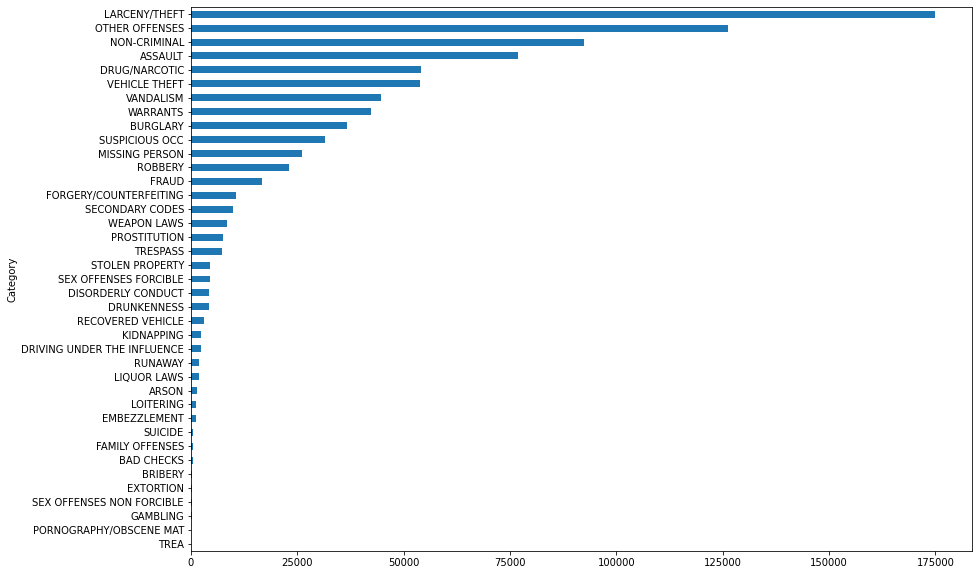

In [4]:
plt.figure(figsize=(14, 10))
train.groupby([train['Category']]).size().sort_values(ascending=True).plot(kind='barh')
plt.show()
# number of each category

好家伙，可以看出绝大部分都是入室盗窃，其他罪行、无罪、袭击也占据一定比例。

In [6]:
full.isnull().sum()

Dates              0
Category      884262
Descript      884262
DayOfWeek          0
PdDistrict         0
Resolution    884262
Address            0
X                  0
Y                  0
dtype: int64

这里的Category就是我们需要做多分类预测的结果。Descript跟Resolution相对影响不大，是对Category的补充说明而已。
这三个特征是用来监督训练结果的，通过Category的种类进行多分类。

所以对Dates、DayOfWeek、PdDistrict、Address、X、Y这几个特征，我们开始做特征的处理。


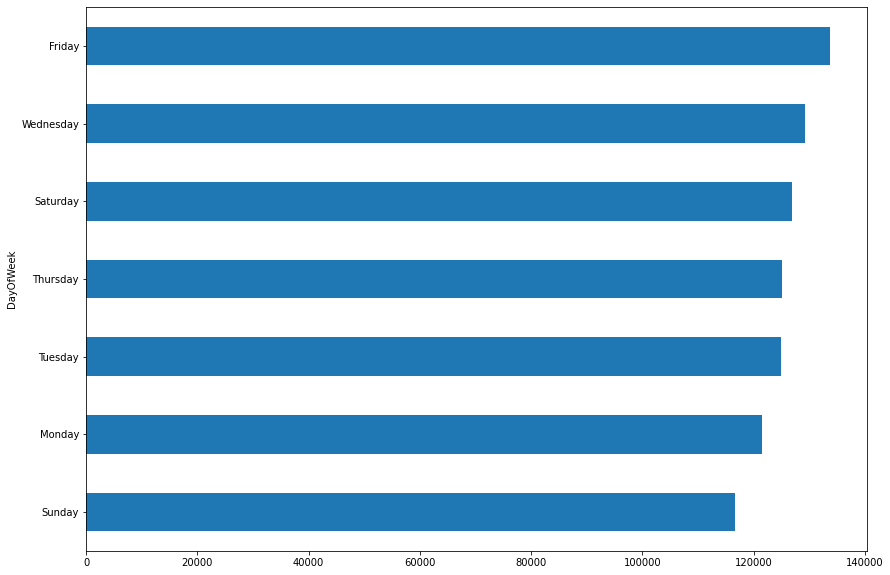

In [7]:
plt.figure(figsize=(14, 10))
train.groupby([train['DayOfWeek']]).size().sort_values(ascending=True).plot(kind='barh')
plt.show()
# distribution about day-of-the-week

可以发现，犯罪的案件数跟是星期中的哪一天关系可以说不是很大，在星期中的每一天都比较均衡。

不过在星期五最多，在星期天最少。这个信息也许可以拆成工作日跟非工作日的一个新特征。

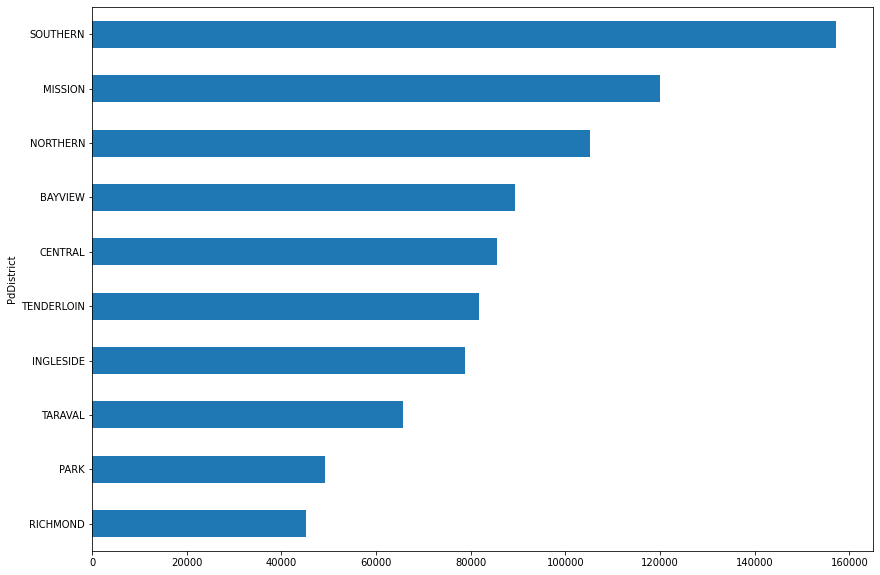

In [8]:
plt.figure(figsize=(14, 10))
train.groupby([train['PdDistrict']]).size().sort_values(ascending=True).plot(kind='barh')
plt.show()
# distribution about PdDistict

SF南部警区出现的犯罪案件数明显多余其他地方，北方跟Mission的警署也挺多的。

In [9]:
# check month
train['Month'] = train['Dates'].map(lambda x: int(x.split('-')[1].strip()))
full['Month'] = full['Dates'].map(lambda x: int(x.split('-')[1].strip()))

In [10]:
def getSeason(n):
    if 3 <= n <= 5:
        return 1
    elif 6 <= n <= 8:
        return 2
    elif 9 <= n <= 11:
        return 3
    elif n == 12 or 1 <= n <= 2:
        return 4
    else:
        return 0

train['Season'] = train['Month'].map(getSeason)
full['Season'] = full['Month'].map(getSeason)

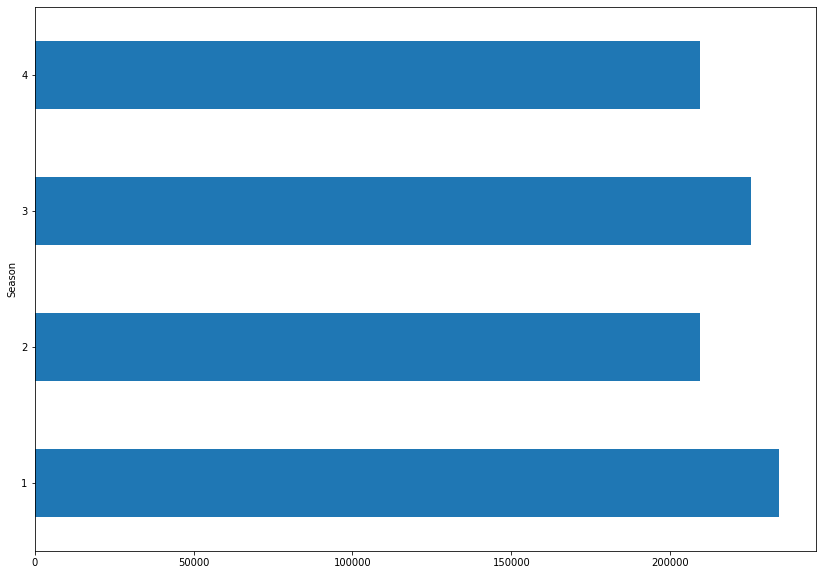

In [11]:
plt.figure(figsize=(14, 10))
train.groupby('Season').size().sort_values(ascending=True).plot(kind='barh')
plt.show()
# distribution about season

In [12]:
def getIsWeekday(day):
    if day == 'Saturday' or day == 'Sunday':
        return 0
    else:
        return 1

train['IsWeekday'] = train['DayOfWeek'].map(getIsWeekday)
full['IsWeekday'] = full['DayOfWeek'].map(getIsWeekday)

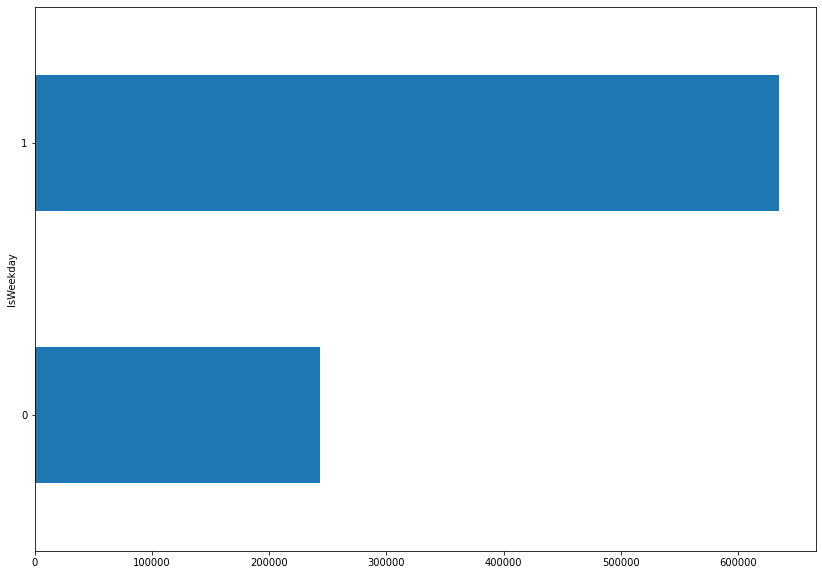

In [13]:
plt.figure(figsize=(14, 10))
train.groupby('IsWeekday').size().sort_values(ascending=True).plot(kind='barh')
plt.show()
# distribution about whether it is weekday

In [14]:
def getHourZone(tim):
    hour = int(tim.split(' ')[1].split(':')[0].strip())
    if 0 <= hour <= 8:
        return 1
    elif 9 <= hour <= 11:
        return 2
    elif 12 <= hour <= 13:
        return 3
    elif 14 <= hour <= 16:
        return 4
    elif 17 <= hour <= 19:
        return 5
    elif 20 <= hour <= 23:
        return 6
    else:
        return 0

train['HourZone'] = train['Dates'].map(getHourZone)
full['HourZone'] = full['Dates'].map(getHourZone)

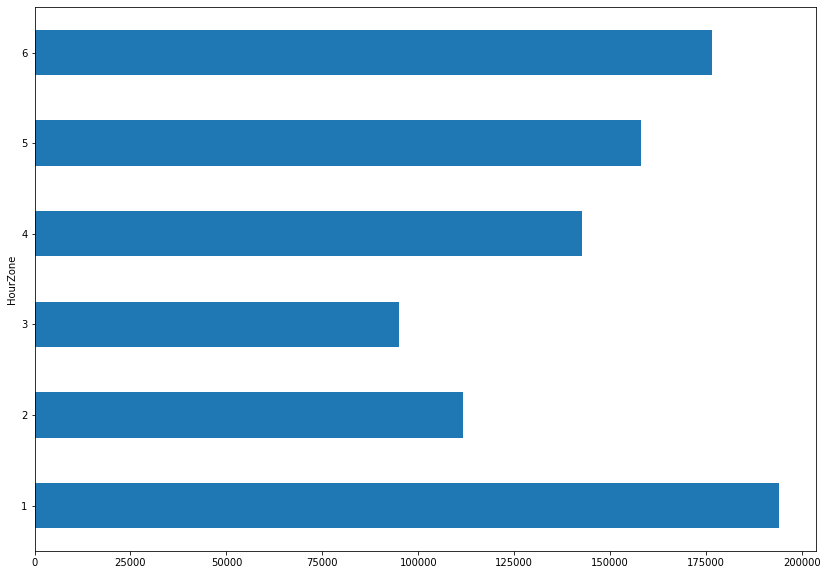

In [15]:
plt.figure(figsize=(14, 10))
train.groupby('HourZone').size().sort_values(ascending=True).plot(kind='barh')
plt.show()
# distribution about whether it is weekday

好家伙，这个数据结果非常符合先验知识，在夜晚的犯罪案件要显著多于白天，并且半夜是最多的。

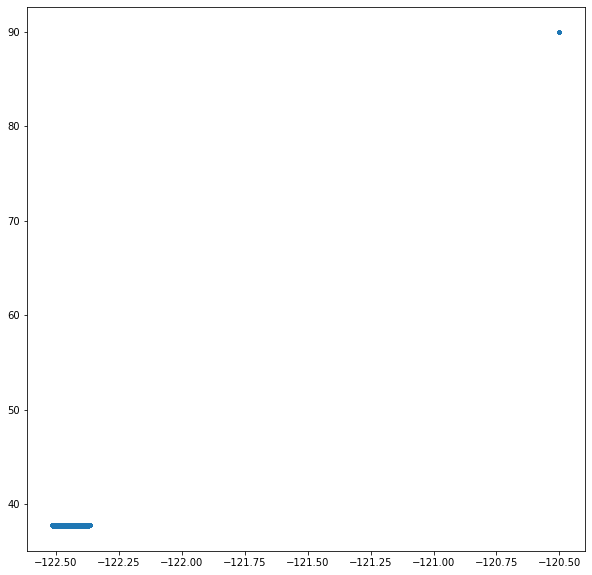

In [16]:
plt.figure(figsize=(10, 10))
plt.scatter(train['X'], train['Y'], marker='.')
plt.show()

维度到了北纬90度就tm离谱。所以我们需要处理异常值，把大于北纬40度的数据全删了。

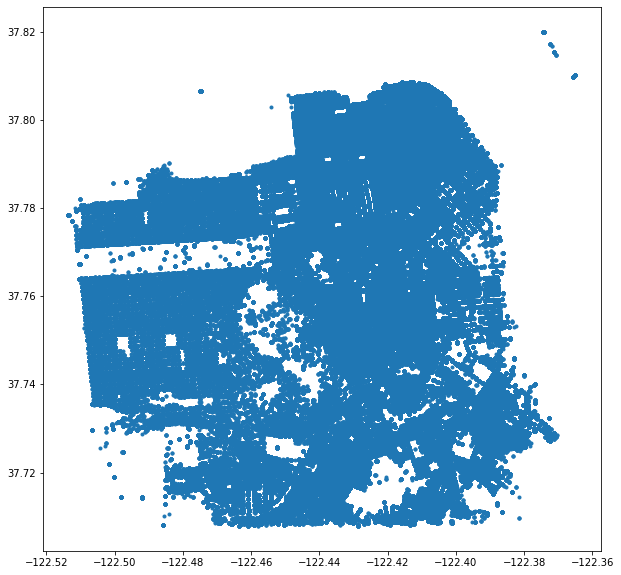

In [17]:
temp = train[train['Y'] < 40]
plt.figure(figsize=(10, 10))
plt.scatter(temp['X'], temp['Y'], marker='.')
plt.show()
# don't change test here

更骚的是，居然在测试集里还出现了76个北纬90度的东西。
肯定是坐标未知，这种情况我们弄个众数、中位数或者平均数塞进去预测一下就差不多了吧，反正不指望预测对。

In [18]:
import re
def getAddressType(addr):
    if '/' in addr:
        return 0
    else:
        return 1

def getAddressNum(addr):
    temp = re.findall(r"\d+", addr)
    if len(temp) == 0:
        return 0
    else:
        return int(temp[0])

train['AddressType'] = train['Address'].map(getAddressType)
train['AddressNum'] = train['Address'].map(getAddressNum)
full['AddressType'] = full['Address'].map(getAddressType)
full['AddressNum'] = full['Address'].map(getAddressNum)

In [19]:
full = full.drop(['Descript', 'Resolution', 'Address', 'Dates'], axis=1)
train = train.drop(['Descript', 'Resolution', 'Address', 'Dates'], axis=1)

In [20]:
full

,Category,DayOfWeek,PdDistrict,X,Y,Month,Season,IsWeekday,HourZone,AddressType,AddressNum
0,WARRANTS,Wednesday,NORTHERN,-122.425892,37.774599,5,1,1,6,0,0
1,OTHER OFFENSES,Wednesday,NORTHERN,-122.425892,37.774599,5,1,1,6,0,0
2,OTHER OFFENSES,Wednesday,NORTHERN,-122.424363,37.800414,5,1,1,6,0,0
3,LARCENY/THEFT,Wednesday,NORTHERN,-122.426995,37.800873,5,1,1,6,1,1500
4,LARCENY/THEFT,Wednesday,PARK,-122.438738,37.771541,5,1,1,6,1,100
...,...,...,...,...,...,...,...,...,...,...,...
1762306,NaN,Wednesday,MISSION,-122.408983,37.751987,1,4,1,1,1,2600
1762307,NaN,Wednesday,NORTHERN,-122.425342,37.792681,1,4,1,1,1,1900
1762308,NaN,Wednesday,INGLESIDE,-122.445418,37.712075,1,4,1,1,1,5500
1762309,NaN,Wednesday,BAYVIEW,-122.387394,37.739479,1,4,1,1,1,1500


In [21]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1762311 entries, 0 to 1762310
Data columns (total 11 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Category     object 
 1   DayOfWeek    object 
 2   PdDistrict   object 
 3   X            float64
 4   Y            float64
 5   Month        int64  
 6   Season       int64  
 7   IsWeekday    int64  
 8   HourZone     int64  
 9   AddressType  int64  
 10  AddressNum   int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 147.9+ MB


In [22]:
week = pd.get_dummies(full['DayOfWeek'], prefix='DayOfWeek', prefix_sep='-')
district = pd.get_dummies(full['PdDistrict'], prefix='PdDistrict', prefix_sep='-')
month = pd.get_dummies(full['Month'], prefix='Month', prefix_sep='-')
season = pd.get_dummies(full['Season'], prefix='Season', prefix_sep='-')
isweekday = pd.get_dummies(full['IsWeekday'], prefix='IsWeekday', prefix_sep='-')
hourzone = pd.get_dummies(full['HourZone'], prefix='HourZone', prefix_sep='-')
addresstype = pd.get_dummies(full['AddressType'], prefix='AddressType', prefix_sep='-')
addressnum = pd.get_dummies(full['AddressNum'], prefix='AddressNum', prefix_sep='-')

full = full.drop(['DayOfWeek', 'PdDistrict', 'Month', 'Season', 'IsWeekday', 'HourZone', 'AddressType', 'AddressNum'], axis=1)
full = pd.concat([full, week, district, month, season, isweekday, hourzone, addresstype, addressnum], axis=1)
full

,Category,X,Y,DayOfWeek-Friday,DayOfWeek-Monday,DayOfWeek-Saturday,DayOfWeek-Sunday,DayOfWeek-Thursday,DayOfWeek-Tuesday,DayOfWeek-Wednesday,...,AddressNum-7400,AddressNum-7500,AddressNum-7600,AddressNum-7700,AddressNum-7800,AddressNum-7900,AddressNum-8000,AddressNum-8100,AddressNum-8200,AddressNum-8300
0,WARRANTS,-122.425892,37.774599,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,OTHER OFFENSES,-122.425892,37.774599,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,OTHER OFFENSES,-122.424363,37.800414,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,LARCENY/THEFT,-122.426995,37.800873,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,LARCENY/THEFT,-122.438738,37.771541,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1762306,NaN,-122.408983,37.751987,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1762307,NaN,-122.425342,37.792681,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1762308,NaN,-122.445418,37.712075,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1762309,NaN,-122.387394,37.739479,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [23]:
train_data = full[full['Category'].notnull()]
test_data = full[full['Category'].isnull()]

train_data = train_data[train_data['Y'] < 40]
from sklearn import preprocessing
label = preprocessing.LabelEncoder()
target = label.fit_transform(train_data['Category'])
len(target)

877982

In [24]:
from sklearn.model_selection import train_test_split
temp = train_data.drop(['Category'], axis=1)
train_x, valid_x, train_y, valid_y = train_test_split(temp, target, train_size=0.7, random_state=0)

In [25]:
from sklearn.metrics import log_loss

In [26]:
# from sklearn.linear_model import LogisticRegression
# LR = LogisticRegression(C=0.1)
# LR.fit(train_x, train_y)
# valid_predicated = np.array(LR.predict_proba(valid_x))
# print("LR loss: %.4f" % (log_loss(valid_y, valid_predicated)))

In [27]:
# from sklearn.naive_bayes import BernoulliNB
# NB = BernoulliNB()
# NB.fit(train_x, train_y)
# valid_predicated = np.array(NB.predict_proba(valid_x))
# print("NB loss: %.4f" % (log_loss(valid_y, valid_predicated)))

In [28]:
# from sklearn.ensemble import RandomForestClassifier
# params = [18, 19]
# for param in params:
#     rfc = RandomForestClassifier(n_estimators=30, max_depth=param)
#     rfc.fit(train_x, train_y)
#     valid_predicated = np.array(rfc.predict_proba(valid_x))
#     print("Random Forest loss: %.4f" % (log_loss(valid_y, valid_predicated)))

In [29]:
print(train_x['X'].mean(), train_x['Y'].mean())
test_data.loc[test_data['Y'] > 40, 'X'] = train_x['X'].mean()
test_data.loc[test_data['Y'] > 40, 'Y'] = train_x['Y'].mean()

-122.42279233301521 37.76703901570792


In [30]:
test_x = test_data.drop('Category', axis=1)
test_x

,X,Y,DayOfWeek-Friday,DayOfWeek-Monday,DayOfWeek-Saturday,DayOfWeek-Sunday,DayOfWeek-Thursday,DayOfWeek-Tuesday,DayOfWeek-Wednesday,PdDistrict-BAYVIEW,...,AddressNum-7400,AddressNum-7500,AddressNum-7600,AddressNum-7700,AddressNum-7800,AddressNum-7900,AddressNum-8000,AddressNum-8100,AddressNum-8200,AddressNum-8300
878049,-122.399588,37.735051,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
878050,-122.391523,37.732432,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
878051,-122.426002,37.792212,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
878052,-122.437394,37.721412,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
878053,-122.437394,37.721412,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1762306,-122.408983,37.751987,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1762307,-122.425342,37.792681,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1762308,-122.445418,37.712075,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1762309,-122.387394,37.739479,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [31]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=30, max_depth=19)
rfc.fit(train_x, train_y)


RandomForestClassifier(max_depth=19, n_estimators=30)

In [32]:
test_y = rfc.predict_proba(test_x)
test_y

array([[3.22602440e-03, 1.32979330e-01, 1.29849267e-04, ...,
        1.82781480e-01, 2.45905089e-02, 1.17394579e-02],
       [1.01997793e-03, 9.76285090e-02, 9.20687804e-05, ...,
        3.52502922e-02, 7.04128892e-02, 3.12650877e-02],
       [1.75720285e-03, 8.61464257e-02, 2.52210077e-04, ...,
        6.78469024e-02, 2.02190553e-02, 5.91282065e-03],
       ...,
       [4.18108770e-03, 1.29400564e-01, 6.55516999e-04, ...,
        9.45083787e-02, 2.69582959e-02, 1.11039854e-02],
       [6.70773005e-03, 1.35094374e-01, 1.01157844e-03, ...,
        7.72223452e-02, 3.78990940e-02, 1.37808121e-02],
       [3.41423285e-03, 8.63380554e-02, 7.90528936e-04, ...,
        6.90332935e-02, 2.33951376e-02, 6.89822095e-03]])

In [33]:
for i in range(test_y.shape[0]):
    test_y[i, np.argmax(test_y[i])] = 1
temp = test_y.astype(int)
temp

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [37]:
ans = pd.DataFrame(temp, columns=label.classes_)
ans.to_csv('submission.csv', index=False)

In [38]:
temp2 = pd.DataFrame(test_id.values.T)
ans.insert(0, 'Id', temp2)
ans.to_csv('submission2.csv', index=False, index_label='Id')

In [39]:
ans

,Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884257,884257,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
884258,884258,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
884259,884259,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
884260,884260,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
